In [16]:
import numpy as np
import scipy
import awkward as ak
import hist as hist2
from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

from coffea.lookup_tools.lookup_base import lookup_base
from coffea import lookup_tools
from coffea import util

import matplotlib.pyplot as plt
from matplotlib import colors
import mplhep as hep
import scipy
hep.style.use(hep.style.CMS)

class SoftDropWeight(lookup_base):
    def _evaluate(self, pt, eta):
        gpar = np.array([1.00626, -1.06161, 0.0799900, 1.20454])
        cpar = np.array([1.09302, -0.000150068, 3.44866e-07, -2.68100e-10, 8.67440e-14, -1.00114e-17])
        fpar = np.array([1.27212, -0.000571640, 8.37289e-07, -5.20433e-10, 1.45375e-13, -1.50389e-17])
        genw = gpar[0] + gpar[1]*np.power(pt*gpar[2], -gpar[3])
        ptpow = np.power.outer(pt, np.arange(cpar.size))
        cenweight = np.dot(ptpow, cpar)
        forweight = np.dot(ptpow, fpar)
        weight = np.where(np.abs(eta) < 1.3, cenweight, forweight)
        return genw*weight

_softdrop_weight = SoftDropWeight()

def corrected_msoftdrop(fatjets):
    sf = _softdrop_weight(fatjets.pt, fatjets.eta)
    sf = np.maximum(1e-5, sf)
    dazsle_msd = (fatjets.subjets * (1 - fatjets.subjets.rawFactor)).sum()
    return dazsle_msd.mass * sf

In [2]:
def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id, 
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def match_HWWlepqq(genparticles,candidatefj):
    """
    return the number of matched objects (hWW*),daughters, 
    and gen flavor (enuqq, munuqq, taunuqq) 
    """
    higgs = getParticles(genparticles,25)
    is_hWW = ak.all(abs(higgs.children.pdgId)==24,axis=2)

    higgs = higgs[is_hWW]
    higgs_wstar = higgs.children[ak.argmin(higgs.children.mass,axis=2,keepdims=True)]
    higgs_w = higgs.children[ak.argmax(higgs.children.mass,axis=2,keepdims=True)]
    
    prompt_electron = getParticles(genparticles,11,11,['isPrompt','isLastCopy'])
    prompt_muon = getParticles(genparticles,13,13,['isPrompt', 'isLastCopy'])
    prompt_tau = getParticles(genparticles,15,15,['isPrompt', 'isLastCopy'])
    prompt_q = getParticles(genparticles,0,5,['fromHardProcess', 'isLastCopy'])
    prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == 24]
    
    dr_fj_quarks = candidatefj.delta_r(prompt_q)
    dr_fj_electrons = candidatefj.delta_r(prompt_electron)
    dr_fj_muons = candidatefj.delta_r(prompt_muon)
    dr_fj_taus = candidatefj.delta_r(prompt_tau)
    dr_daughters = ak.concatenate([dr_fj_quarks,dr_fj_electrons,dr_fj_muons,dr_fj_taus],axis=1)
    hWWlepqq_nprongs = ak.sum(dr_daughters<0.8,axis=1)
    
    n_electrons = ak.sum(prompt_electron.pt>0,axis=1)
    n_muons = ak.sum(prompt_muon.pt>0,axis=1)
    n_taus = ak.sum(prompt_tau.pt>0,axis=1)
    n_quarks = ak.sum(prompt_q.pt>0,axis=1)

    # 4(elenuqq),6(munuqq),8(taunuqq)
    hWWlepqq_flavor = (n_quarks==2)*1 + (n_electrons==1)*3 + (n_muons==1)*5 + (n_taus==1)*7
    
    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
    matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)
    matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8) 

    # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
    hWWlepqq_matched = (
        (ak.sum(matchedH.pt > 0, axis=1)==1) * 1 
        + (ak.sum(ak.flatten(matchedW.pt > 0, axis=2), axis=1)==1) * 3 
        + (ak.sum(ak.flatten(matchedWstar.pt > 0, axis=2), axis=1)==1) * 5
    )
    
    # leptons matched
    dr_leptons = ak.concatenate([dr_fj_electrons,dr_fj_muons], axis=1)
    matched_leptons = dr_leptons < 0.8
    
    leptons = ak.concatenate([prompt_electron, prompt_muon], axis=1)
    leptons = leptons[matched_leptons]
    
    # leptons coming from W or W*
    leptons_mass = ak.firsts(leptons.distinctParent.mass)
    higgs_w_mass = ak.firsts(ak.flatten(higgs_w.mass))[ak.firsts(leptons.pt > 0)]
    higgs_wstar_mass = ak.firsts(ak.flatten(higgs_wstar.mass))[ak.firsts(leptons.pt > 0)]

    iswlepton = leptons_mass == higgs_w_mass
    iswstarlepton = leptons_mass == higgs_wstar_mass
    
    return hWWlepqq_flavor,hWWlepqq_matched,hWWlepqq_nprongs,matchedH,higgs,iswlepton,iswstarlepton


class HwwSignalProcessor(processor.ProcessorABC):
    def __init__(self, year="2017", jet_arbitration='met', el_wp="wp80"):
        self._year = year
        self._jet_arbitration = jet_arbitration
        self._el_wp = el_wp
        
        self._triggers = {
            2016: {
                'e': [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165",
                    "Ele115_CaloIdVT_GsfTrkIdT",
                    "Ele15_IsoVVVL_PFHT600",
                ],
                'mu': [
                    "Mu50",
                    "Mu55",
                    "Mu15_IsoVVVL_PFHT600",
                ],
            },
            2017: {
                'e': [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165",
                    "Ele115_CaloIdVT_GsfTrkIdT",
                    "Ele15_IsoVVVL_PFHT600",
                ],
                'mu': [
                    "Mu50",
                    "Mu15_IsoVVVL_PFHT600",
                ],
            },
            2018: {
                'e': [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165",
                    "Ele115_CaloIdVT_GsfTrkIdT",
                    "Ele15_IsoVVVL_PFHT600",
                ],
                'mu': [
                    "Mu50",
                    "Mu15_IsoVVVL_PFHT600",
                ],
            }
        }
        self._triggers = self._triggers[int(self._year)]

        # output
        self.make_output = lambda: {
            'sumw': 0.,
            'signal_kin': hist2.Hist(
                hist2.axis.StrCategory([], name="region", growth=True),
                hist2.axis.IntCategory([0, 2, 4, 6, 8], name='genflavor', label='gen flavor'),
                hist2.axis.IntCategory([0, 1, 4, 6, 9], name='genHflavor', label='higgs matching'),
                hist2.axis.IntCategory([0, 1, 2, 3, 4], name='nprongs', label='Jet nprongs'),
                hist2.storage.Weight(),
            ),
            "jet_kin": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.Regular(30, 200, 1000, name='jetpt', label=r'Jet $p_T$ [GeV]'),
                hist2.axis.Regular(30, 15, 200, name="jetmsd", label="Jet $m_{sd}$ [GeV]"),
                hist2.axis.Regular(25, -20, 0, name="jetrho", label=r"Jet $\rho$"),
                hist2.axis.Regular(20, 0, 1, name="btag", label="Jet btag (opphem)"),
                hist2.storage.Weight(),
            ),
            "lep_kin": hist2.Hist(
                hist2.axis.StrCategory([], name="region", growth=True),
                hist2.axis.Regular(25, 0, 1, name="lepminiIso", label="lep miniIso"),
                hist2.axis.Regular(25, 0, 1, name="leprelIso", label="lep Rel Iso"),
                hist2.axis.Regular(40, 10, 800, name='lep_pt', label=r'lep $p_T$ [GeV]'),
                hist2.axis.Regular(30, 0, 5, name="deltaR_lepjet", label="$\Delta R(l, Jet)$"),
                hist2.storage.Weight(),
            ),
            "higgs_kin": hist2.Hist(
                hist2.axis.StrCategory([], name="region", growth=True),
                hist2.axis.Regular(50, 10, 1000, name='matchedHpt', label=r'matched H $p_T$ [GeV]'),
                hist2.axis.Variable(
                    [10,35,60,85,110,135,160,185,210,235,260,285,310,335,360,385,410,450,490,530,570,615,665,715,765,815,865,915,965],
                    name='genHpt', 
                    label=r'genH $p_T$ [GeV]',
                ),
                hist2.storage.Weight(),
            ),
            "met_kin": hist2.Hist(
                hist2.axis.StrCategory([], name="region", growth=True),
                hist2.axis.Regular(30, 0, 500, name="met", label=r"$p_T^{miss}$ [GeV]"),
                hist2.storage.Weight(),
            ),
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        selection = PackedSelection()
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)

        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
            
        # trigger
        for channel in ["e","mu"]:
            trigger = np.zeros(len(events), dtype='bool')
            for t in self._triggers[channel]:
                if t in events.HLT.fields:
                    trigger = trigger | events.HLT[t]
            selection.add('trigger'+channel, trigger)
            del trigger

        # leptons
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        lowptmuon = (
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.looseId
        )
        nlowptmuons = ak.sum(lowptmuon, axis=1)
            
        if self._el_wp == "wp80":
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
                & (events.Electron.mvaFall17V2noIso_WP80)
            )
        elif self._el_wp == "wp90":
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
                & (events.Electron.mvaFall17V2noIso_WP90)
            )
        elif self._el_wp == "wpl":
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
                & (events.Electron.mvaFall17V2noIso_WPL)
            )
        elif not self.el_wp:
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
            )
        else:
            raise RuntimeError("Unknown working point")
                
        nelectrons = ak.sum(goodelectron, axis=1)
        lowptelectron = (
            (events.Electron.pt > 10)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        nlowptelectrons = ak.sum(lowptelectron, axis=1)

        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)
            
        selection.add('onemuon', (nmuons == 1) & (nlowptmuons <= 1) & (nelectrons == 0) & (nlowptelectrons == 0) & (ntaus == 0))
        selection.add('oneelectron', (nelectrons == 1) & (nlowptelectrons <= 1) & (nmuons == 0) & (nlowptmuons == 0) & (ntaus == 0))
            
        # concatenate leptons and select leading one
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        candidatelep_p4 = ak.zip(
            {
                "pt": candidatelep.pt,
                "eta": candidatelep.eta,
                "phi": candidatelep.phi,
                "mass": candidatelep.mass,
                "charge": candidatelep.charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
            
        # lepton isolation
        lep_miniIso = candidatelep.miniPFRelIso_all
        lep_relIso = candidatelep.pfRelIso03_all

        selection.add("miniIso1", lep_miniIso < 0.1)
        selection.add("miniIso2", lep_miniIso < 0.2)
        selection.add("relIso1", lep_relIso < 0.1)
        selection.add("relIso2", lep_relIso < 0.2)
            
        # missing transverse energy
        met = events.MET

        # fatjets
        fatjets = events.FatJet
        fatjets["msdcorr"] = corrected_msoftdrop(fatjets)
        fatjets["qcdrho"] = 2 * np.log(fatjets.msdcorr / fatjets.pt)
        
        candidatefj = fatjets[
            (fatjets.pt > 200)
        ]
        dphi_met_fj = abs(candidatefj.delta_phi(met))
        dr_lep_fj = candidatefj.delta_r(candidatelep_p4)

        if self._jet_arbitration == 'pt':
            candidatefj = ak.firsts(candidatefj)
        elif self._jet_arbitration == 'met':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        elif self._jet_arbitration == 'lep':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dr_lep_fj,axis=1,keepdims=True)])
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
            
                
        # leptons within fj
        lep_in_fj = candidatefj.delta_r(candidatelep_p4) < 0.8
        lep_in_fj = ak.fill_none(lep_in_fj, False)
        selection.add("lep_in_fj", lep_in_fj)
        
        # jets
        jets = events.Jet
        jets = jets[
            (jets.pt > 30) 
            & (abs(jets.eta) < 2.5) 
            & jets.isTight
        ][:,:4]
        
        dphi_jet_fj = abs(jets.delta_phi(candidatefj))
        dr_jet_fj = abs(jets.delta_r(candidatefj))
        
        # b-jets
        bjets_ophem = ak.max(jets[dphi_jet_fj > np.pi / 2].btagDeepFlavC, axis=1)
        selection.add("btag_ophem", bjets_ophem > 0)

        # match HWWlepqq 
        hWWlepqq_flavor,hWWlepqq_matched,hWWlepqq_nprongs,matchedH,genH,iswlepton,iswstarlepton = match_HWWlepqq(events.GenPart,candidatefj)
    
        matchedH_pt = ak.firsts(matchedH.pt)
        selection.add("matchedH", matchedH_pt > 0)
    
        selection.add("iswlepton", iswlepton)
        selection.add("iswstarlepton", iswstarlepton)
        
        regions = {
            #"hadel": ["triggere", "oneelectron"],
            #"hadmu": ["triggermu", "onemuon"] ,
            "iswlepton": ["lep_in_fj", "iswlepton", ],
            "iswstarlepton": ["lep_in_fj", "iswstarlepton"]
        }

        # function to normalize arrays after a cut or selection
        def normalize(val, cut=None):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
        
        
        def fill(region):
            selections = regions[region]
            cut = selection.all(*selections)

            output['signal_kin'].fill(
                region=region,
                genflavor=normalize(hWWlepqq_flavor, cut),
                genHflavor=normalize(hWWlepqq_matched, cut),
                nprongs=normalize(hWWlepqq_nprongs, cut),
                weight = weights.weight()[cut],
            )
            output["jet_kin"].fill(
                region=region,
                jetpt=normalize(candidatefj.pt, cut),
                jetmsd=normalize(candidatefj.msdcorr, cut),
                jetrho=normalize(candidatefj.qcdrho, cut),
                btag=normalize(bjets_ophem, cut),
                weight=weights.weight()[cut],
            )
            output['lep_kin'].fill(
                region=region,
                lepminiIso=normalize(lep_miniIso, cut),
                leprelIso=normalize(lep_relIso, cut),
                lep_pt=normalize(candidatelep.pt, cut),
                deltaR_lepjet=normalize(candidatefj.delta_r(candidatelep_p4), cut),
                weight=weights.weight()[cut],
            )
            output['higgs_kin'].fill(
                region=region,
                matchedHpt=normalize(matchedH_pt, cut),
                genHpt=normalize(ak.firsts(genH.pt), cut),
                weight=weights.weight()[cut],
            )
            output["met_kin"].fill(
                region=region,
                met=normalize(met.pt, cut),
                weight=weights.weight()[cut],
            )

        for region in regions:
                fill(region)

        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [4]:
class BackgroundProcessor(processor.ProcessorABC):
    def __init__(self, year="2017", jet_arbitration='met', el_wp="wp80"):
        self._year = year
        self._jet_arbitration = jet_arbitration
        self._el_wp = el_wp
        
        self._triggers = {
            2016: {
                'e': [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165",
                    "Ele115_CaloIdVT_GsfTrkIdT",
                    "Ele15_IsoVVVL_PFHT600",
                ],
                'mu': [
                    "Mu50",
                    "Mu55",
                    "Mu15_IsoVVVL_PFHT600",
                ],
            },
            2017: {
                'e': [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165",
                    "Ele115_CaloIdVT_GsfTrkIdT",
                    "Ele15_IsoVVVL_PFHT600",
                ],
                'mu': [
                    "Mu50",
                    "Mu15_IsoVVVL_PFHT600",
                ],
            },
            2018: {
                'e': [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165",
                    "Ele115_CaloIdVT_GsfTrkIdT",
                    "Ele15_IsoVVVL_PFHT600",
                ],
                'mu': [
                    "Mu50",
                    "Mu15_IsoVVVL_PFHT600",
                ],
            }
        }
        self._triggers = self._triggers[int(self._year)]

        # output
        self.make_output = lambda: {
            'sumw': 0.,
            "jet_kin": hist2.Hist(
                hist2.axis.StrCategory([], name='region', growth=True),
                hist2.axis.Regular(30, 200, 1000, name='jetpt', label=r'Jet $p_T$ [GeV]'),
                hist2.axis.Regular(30, 15, 200, name="jetmsd", label="Jet $m_{sd}$ [GeV]"),
                hist2.axis.Regular(25, -20, 0, name="jetrho", label=r"Jet $\rho$"),
                hist2.axis.Regular(20, 0, 1, name="btag", label="Jet btag (opphem)"),
                hist2.storage.Weight(),
            ),
            "lep_kin": hist2.Hist(
                hist2.axis.StrCategory([], name="region", growth=True),
                hist2.axis.Regular(25, 0, 1, name="lepminiIso", label="lep miniIso"),
                hist2.axis.Regular(25, 0, 1, name="leprelIso", label="lep Rel Iso"),
                hist2.axis.Regular(40, 10, 800, name='lep_pt', label=r'lep $p_T$ [GeV]'),
                hist2.axis.Regular(30, 0, 5, name="deltaR_lepjet", label="$\Delta R(l, Jet)$"),
                hist2.storage.Weight(),
            ),
            "met_kin": hist2.Hist(
                hist2.axis.StrCategory([], name="region", growth=True),
                hist2.axis.Regular(30, 0, 500, name="met", label="MET [GeV]"),
                hist2.storage.Weight(),
            ),
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        selection = PackedSelection()
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)

        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
            
        # trigger
        for channel in ["e","mu"]:
            trigger = np.zeros(len(events), dtype='bool')
            for t in self._triggers[channel]:
                if t in events.HLT.fields:
                    trigger = trigger | events.HLT[t]
            selection.add('trigger'+channel, trigger)
            del trigger

        # leptons
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        lowptmuon = (
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.looseId
        )
        nlowptmuons = ak.sum(lowptmuon, axis=1)
            
        if self._el_wp == "wp80":
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
                & (events.Electron.mvaFall17V2noIso_WP80)
            )
        elif self._el_wp == "wp90":
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
                & (events.Electron.mvaFall17V2noIso_WP90)
            )
        elif self._el_wp == "wpl":
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
                & (events.Electron.mvaFall17V2noIso_WPL)
            )
        elif not self.el_wp:
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
            )
        else:
            raise RuntimeError("Unknown working point")
                
        nelectrons = ak.sum(goodelectron, axis=1)
        lowptelectron = (
            (events.Electron.pt > 10)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        nlowptelectrons = ak.sum(lowptelectron, axis=1)

        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)
            
        selection.add('onemuon', (nmuons == 1) & (nlowptmuons <= 1) & (nelectrons == 0) & (nlowptelectrons == 0) & (ntaus == 0))
        selection.add('oneelectron', (nelectrons == 1) & (nlowptelectrons <= 1) & (nmuons == 0) & (nlowptmuons == 0) & (ntaus == 0))
            
        # concatenate leptons and select leading one
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        candidatelep_p4 = ak.zip(
            {
                "pt": candidatelep.pt,
                "eta": candidatelep.eta,
                "phi": candidatelep.phi,
                "mass": candidatelep.mass,
                "charge": candidatelep.charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
            
        # lepton isolation
        lep_miniIso = candidatelep.miniPFRelIso_all
        lep_relIso = candidatelep.pfRelIso03_all

        selection.add("miniIso1", lep_miniIso < 0.1)
        selection.add("miniIso2", lep_miniIso < 0.2)
        selection.add("relIso1", lep_relIso < 0.1)
        selection.add("relIso2", lep_relIso < 0.2)
            
        # missing transverse energy
        met = events.MET

        # fatjets
        fatjets = events.FatJet
        fatjets["msdcorr"] = corrected_msoftdrop(fatjets)
        fatjets["qcdrho"] = 2 * np.log(fatjets.msdcorr / fatjets.pt)
        
        candidatefj = fatjets[
            (fatjets.pt > 200)
        ]
        dphi_met_fj = abs(candidatefj.delta_phi(met))
        dr_lep_fj = candidatefj.delta_r(candidatelep_p4)

        if self._jet_arbitration == 'pt':
            candidatefj = ak.firsts(candidatefj)
        elif self._jet_arbitration == 'met':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        elif self._jet_arbitration == 'lep':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dr_lep_fj,axis=1,keepdims=True)])
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
            
                
        # leptons within fj
        lep_in_fj = candidatefj.delta_r(candidatelep_p4) < 0.8
        lep_in_fj = ak.fill_none(lep_in_fj, False)
        selection.add("lep_in_fj", lep_in_fj)
        
        # jets
        jets = events.Jet
        jets= jets[
            (jets.pt > 30) 
            & (abs(jets.eta) < 2.5) 
            & jets.isTight
        ][:,:4]
        
        dphi_jet_fj = abs(jets.delta_phi(candidatefj))
        dr_jet_fj = abs(jets.delta_r(candidatefj))
        
        # b-jets
        bjets_ophem = ak.max(jets[dphi_jet_fj > np.pi / 2].btagDeepFlavC, axis=1)
        selection.add("btag_ophem", bjets_ophem > 0)

        regions = {
            #"hadel": ["triggere", "oneelectron", "miniIso1"],
            #"hadmu": ["triggermu", "onemuon", "miniIso1"] ,
            "lep_in_fj": ["lep_in_fj"]
        }

        # function to normalize arrays after a cut or selection
        def normalize(val, cut=None):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
                
        
        def fill(region):
            selections = regions[region]
            cut = selection.all(*selections)

            output["jet_kin"].fill(
                region=region,
                jetpt=normalize(candidatefj.pt, cut),
                jetmsd=normalize(candidatefj.msdcorr, cut),
                jetrho=normalize(candidatefj.qcdrho, cut),
                btag=normalize(bjets_ophem, cut),
                weight=weights.weight()[cut],
            )
            output['lep_kin'].fill(
                region=region,
                lepminiIso=normalize(lep_miniIso, cut),
                leprelIso=normalize(lep_relIso, cut),
                lep_pt=normalize(candidatelep.pt, cut),
                deltaR_lepjet=normalize(candidatefj.delta_r(candidatelep_p4), cut),
                weight=weights.weight()[cut],
            )
            output["met_kin"].fill(
                region=region,
                met=normalize(met.pt, cut),
                weight=weights.weight()[cut],
            )

        for region in regions:
                fill(region)

        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [3]:
from dask.distributed import Client

client = Client("tls://daniel-2eocampo-2ehenao-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.134.237:8786' processes=1 threads=2, memory=7.00 GiB>

In [5]:
fileset = {
    'HWW': ["root://xcache/" + file for file in np.loadtxt("data/hwwdata.txt", dtype=str)]
}

hwwout = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=HwwSignalProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
)

In [6]:
fileset = {
    "tt": 
    ["root://xcache/" + file for file in np.loadtxt("data/ttsemileptonicdata.txt", dtype=str)]
}

ttout = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
    maxchunks=30,
)

In [7]:
fileset = {
    "qcd": 
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht300to500data.txt", dtype=str)] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht500to700data.txt", dtype=str)] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht700to1000data.txt", dtype=str)] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht1000to1500data.txt", dtype=str)] +
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht1500to2000data.txt", dtype=str)] + 
    ["root://xcache/" + file for file in np.loadtxt("data/qcdht2000toInfdata.txt", dtype=str)]
}

qcdout = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
    maxchunks=30,
)

In [8]:
fileset = {
    "wjets": 
    ["root://xcache/" + file for file in np.loadtxt("data/wjets200400.txt", dtype=str)] +
    ["root://xcache/" + file for file in np.loadtxt("data/wjets400600.txt", dtype=str)] +
    ["root://xcache/" + file for file in np.loadtxt("data/wjets600800.txt", dtype=str)] +
    ["root://xcache/" + file for file in np.loadtxt("data/wjets8001200.txt", dtype=str)] +
    ["root://xcache/" + file for file in np.loadtxt("data/wjets12002500.txt", dtype=str)] + 
    ["root://xcache/" + file for file in np.loadtxt("data/wjets2500Inf.txt", dtype=str)]
}

wjetsout = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
    maxchunks=30,
)

In [12]:
jet_kin_signal = hwwout["HWW"]["jet_kin"]
jet_kin_tt = ttout["tt"]["jet_kin"]
jet_kin_qcd = qcdout["qcd"]["jet_kin"]
jet_kin_wjets = wjetsout["wjets"]["jet_kin"]

In [17]:
def plot_hist(sig, sigW, sigWstar, tt, qcd, wjets, loc="best"):
    fig, ax = plt.subplots(
        figsize=(10,7),
        tight_layout=True,
    )
    wjets.plot1d(
        ax=ax,
        density=True,
        stack=True,
        histtype="fill",
        edgecolor="k",
        color="sandybrown",
        label=r"W($l\nu$)",
    )
    qcd.plot1d(
        ax=ax,
        density=True,
        stack=True,
        histtype="fill",
        edgecolor="k",
        color="olivedrab",#"yellowgreen",
        label="qcd",
    )
    tt.plot1d(
        ax=ax,
        density=True,
        stack=True,
        histtype="fill",
        edgecolor="k",
        color="mediumslateblue",
        label=r"$t\bar{t}$ (semileptonic)"
    )
    sig.plot1d(
        ax=ax,
        density=True,
        lw=3,
        stack=True,
        color="k",
        label="$HWW$",
    )
    sigW.plot1d(
        ax=ax,
        density=True,
        lw=3,
        stack=True,
        color="r",
        label="$HWW$ (lepton from W)",
    )
    sigWstar.plot1d(
        ax=ax,
        density=True,
        lw=3,
        stack=True,
        color="darkorange",
        label="$HWW$ (lepton from W*)",
    )
    
    
    ax.set(
    ylabel="Events",
    )
    ax.legend(
        frameon=True,
        loc=loc
    );

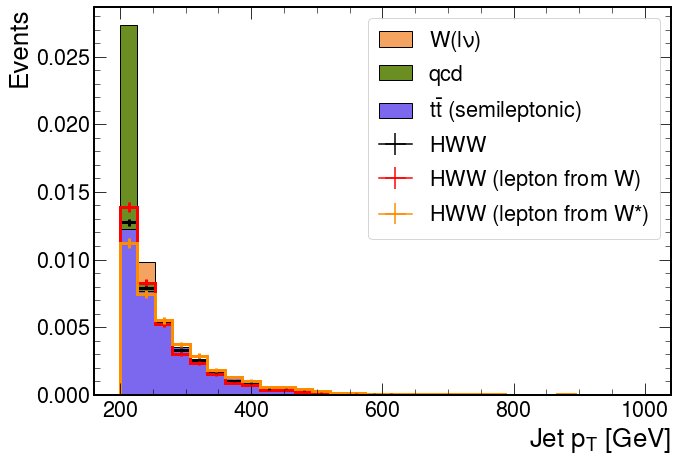

In [19]:
sig = jet_kin_signal[{"region":sum, "jetmsd":sum, "jetrho":sum, "btag":sum}]
sigW = jet_kin_signal[{"region":"iswlepton", "jetmsd":sum, "jetrho":sum, "btag":sum}]
sigWstar = jet_kin_signal[{"region":"iswstarlepton", "jetmsd":sum, "jetrho":sum, "btag":sum}]
qcd = jet_kin_qcd[{"region":sum, "jetmsd":sum, "jetrho":sum, "btag":sum}]
tt = jet_kin_tt[{"region":sum, "jetmsd":sum, "jetrho":sum, "btag":sum}]
wjets = jet_kin_wjets[{"region":sum, "jetmsd":sum, "jetrho":sum, "btag":sum}]

plot_hist(sig, sigW, sigWstar, tt, qcd, wjets);

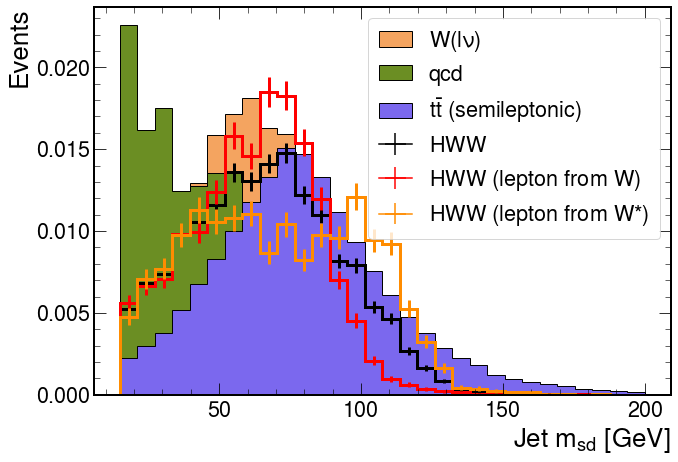

In [20]:
sig = jet_kin_signal[{"region":sum, "jetpt":sum, "jetrho":sum, "btag":sum}]
sigW = jet_kin_signal[{"region":"iswlepton", "jetpt":sum, "jetrho":sum, "btag":sum}]
sigWstar = jet_kin_signal[{"region":"iswstarlepton", "jetpt":sum, "jetrho":sum, "btag":sum}]
qcd = jet_kin_qcd[{"region":sum, "jetpt":sum, "jetrho":sum, "btag":sum}]
tt = jet_kin_tt[{"region":sum, "jetpt":sum, "jetrho":sum, "btag":sum}]
wjets = jet_kin_wjets[{"region":sum, "jetpt":sum, "jetrho":sum, "btag":sum}]

plot_hist(sig, sigW, sigWstar, tt, qcd, wjets)

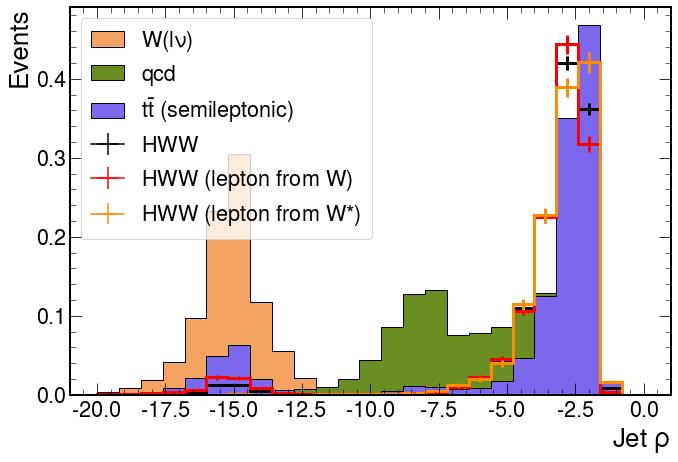

In [22]:
sig = jet_kin_signal[{"region":sum, "jetpt":sum, "jetmsd":sum, "btag":sum}]
sigW = jet_kin_signal[{"region":"iswlepton", "jetpt":sum, "jetmsd":sum, "btag":sum}]
sigWstar = jet_kin_signal[{"region":"iswstarlepton", "jetpt":sum, "jetmsd":sum, "btag":sum}]
qcd = jet_kin_qcd[{"region":sum, "jetpt":sum, "jetmsd":sum, "btag":sum}]
tt = jet_kin_tt[{"region":sum, "jetpt":sum, "jetmsd":sum, "btag":sum}]
wjets = jet_kin_wjets[{"region":sum, "jetpt":sum, "jetmsd":sum, "btag":sum}]

plot_hist(sig, sigW, sigWstar, tt, qcd, wjets)

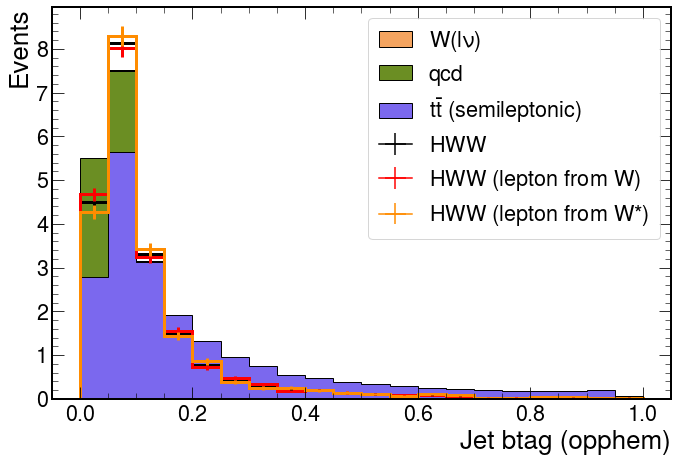

In [23]:
sig = jet_kin_signal[{"region":sum, "jetpt":sum, "jetmsd":sum, "jetrho":sum}]
sigW = jet_kin_signal[{"region":"iswlepton", "jetpt":sum, "jetmsd":sum, "jetrho":sum}]
sigWstar = jet_kin_signal[{"region":"iswstarlepton", "jetpt":sum, "jetmsd":sum, "jetrho":sum}]
qcd = jet_kin_qcd[{"region":sum, "jetpt":sum, "jetmsd":sum, "jetrho":sum}]
tt = jet_kin_tt[{"region":sum, "jetpt":sum, "jetmsd":sum, "jetrho":sum}]
wjets = jet_kin_wjets[{"region":sum, "jetpt":sum, "jetmsd":sum, "jetrho":sum}]

plot_hist(sig, sigW, sigWstar, tt, qcd, wjets)

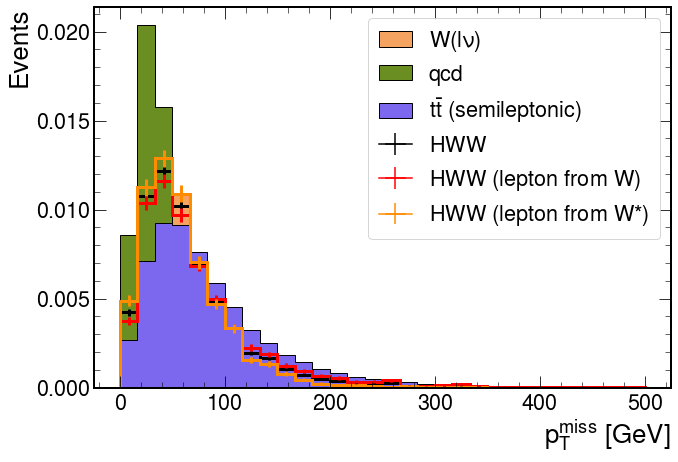

In [24]:
met_signal = hwwout["HWW"]["met_kin"][{"region":sum}]
met_signalW = hwwout["HWW"]["met_kin"][{"region":"iswlepton"}]
met_signalWstar = hwwout["HWW"]["met_kin"][{"region":"iswstarlepton"}]
met_tt = ttout["tt"]["met_kin"][{"region":sum}]
met_qcd = qcdout["qcd"]["met_kin"][{"region":sum}]
met_wjets = wjetsout["wjets"]["met_kin"][{"region":sum}]

plot_hist(met_signal, met_signalW, met_signalWstar, met_tt, met_qcd, met_wjets)

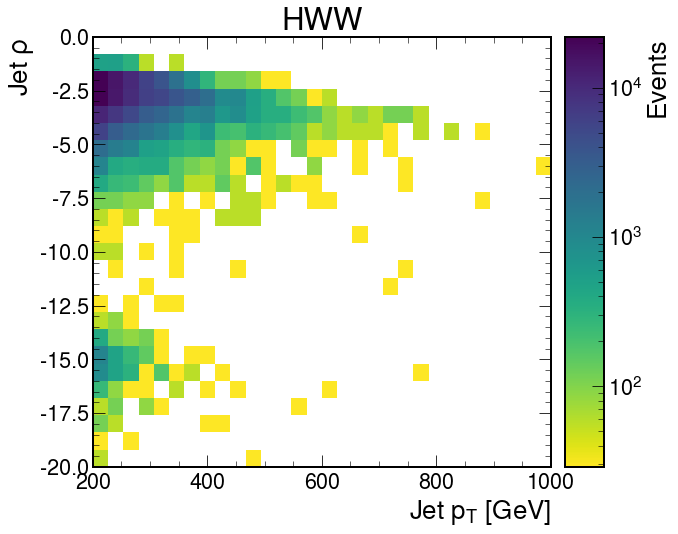

In [26]:
fig, ax = plt.subplots(
    figsize=(10,8),
    tight_layout=True,
)

hist = jet_kin_signal[{"region":sum, "jetmsd":sum, "btag":sum}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)
hist.cbar.set_label("Events")
ax.set(
    title="HWW"
);

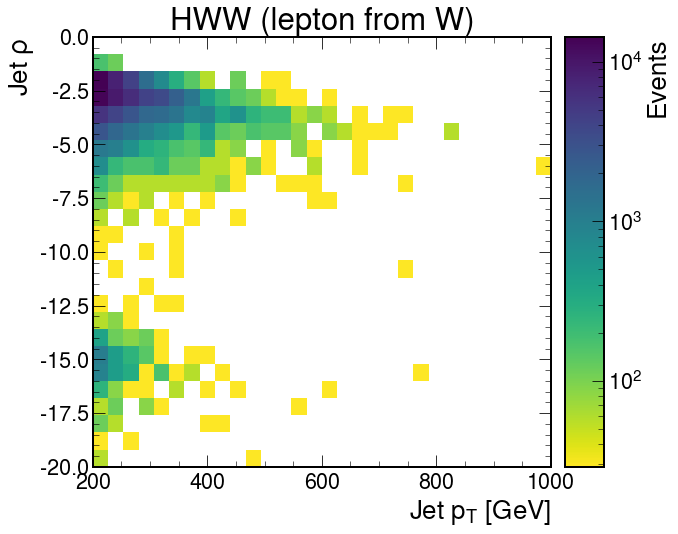

In [27]:
fig, ax = plt.subplots(
    figsize=(10,8),
    tight_layout=True,
)

hist = jet_kin_signal[{"region":"iswlepton", "jetmsd":sum, "btag":sum}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)
hist.cbar.set_label("Events")
ax.set(
    title="HWW (lepton from W)"
);

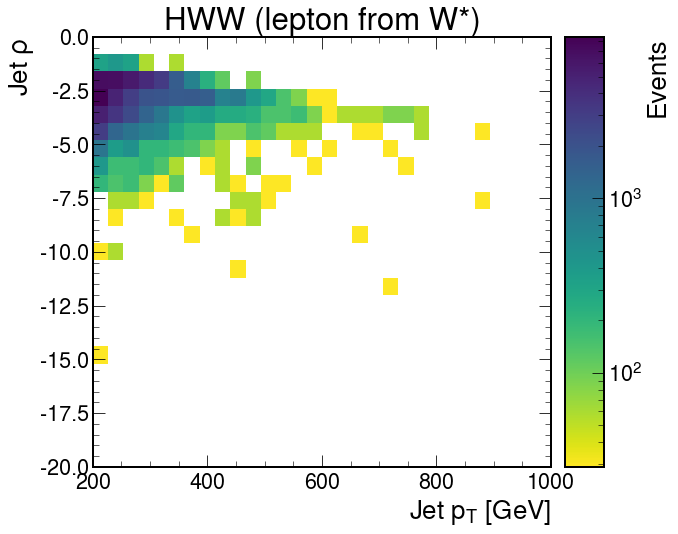

In [28]:
fig, ax = plt.subplots(
    figsize=(10,8),
    tight_layout=True,
)

hist = jet_kin_signal[{"region":"iswstarlepton", "jetmsd":sum, "btag":sum}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)
hist.cbar.set_label("Events")
ax.set(
    title="HWW (lepton from W*)"
);

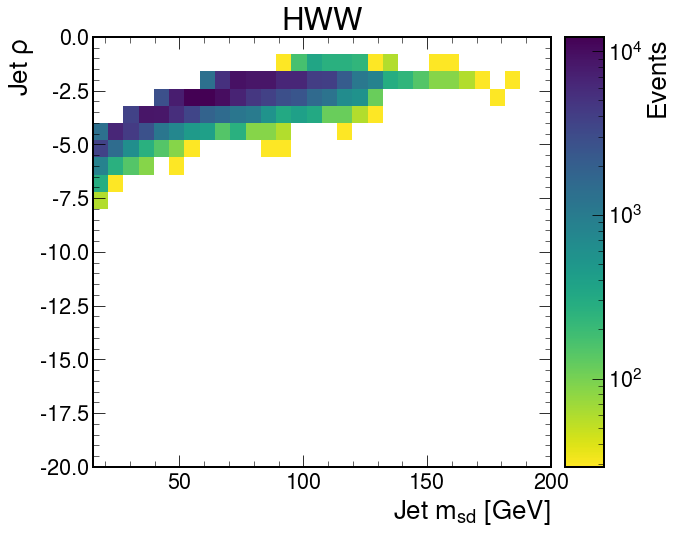

In [29]:
fig, ax = plt.subplots(
    figsize=(10,8),
    tight_layout=True,
)

hist = jet_kin_signal[{"region":sum, "jetpt":sum, "btag":sum}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)
hist.cbar.set_label("Events")
ax.set(
    title="HWW",
);

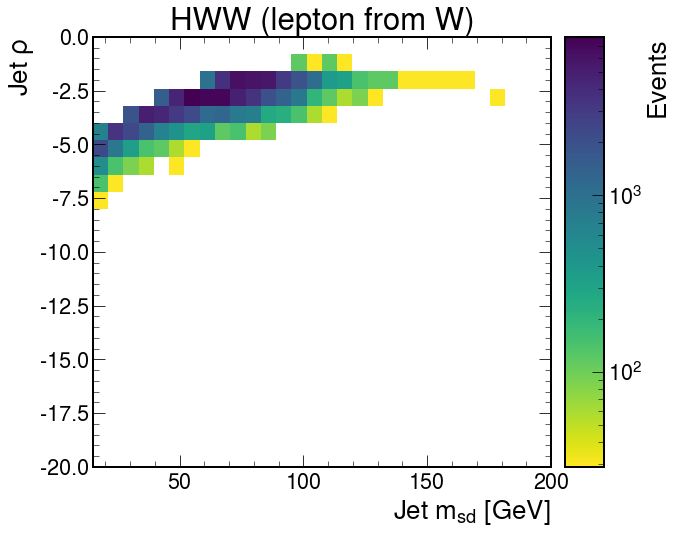

In [30]:
fig, ax = plt.subplots(
    figsize=(10,8),
    tight_layout=True,
)

hist = jet_kin_signal[{"region":"iswlepton", "jetpt":sum, "btag":sum}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)
hist.cbar.set_label("Events")
ax.set(
    title="HWW (lepton from W)",
);

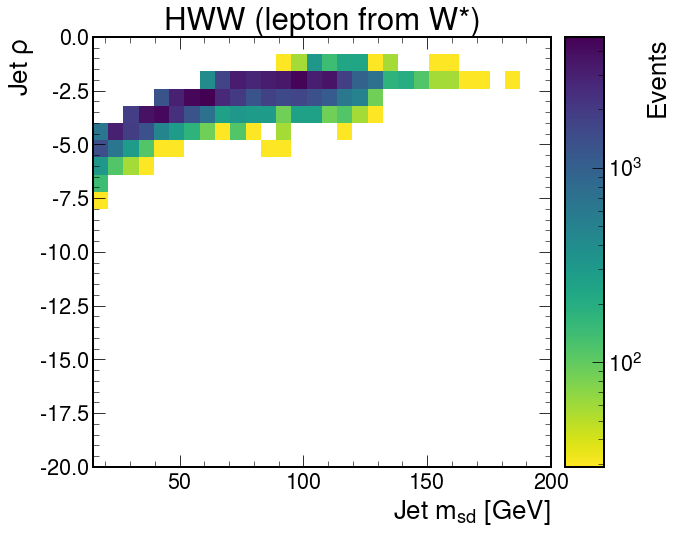

In [31]:
fig, ax = plt.subplots(
    figsize=(10,8),
    tight_layout=True,
)

hist = jet_kin_signal[{"region":"iswstarlepton", "jetpt":sum, "btag":sum}].plot2d(
    ax=ax,
    norm=colors.LogNorm(),
    cmap="viridis_r",
)
hist.cbar.set_label("Events")
ax.set(
    title="HWW (lepton from W*)",
);